# Neural Machine Translation using Seq2Seq Modelling using PyTorch
- https://colab.research.google.com/github/bala-codes/Natural-Language-Processing-NLP/blob/master/Neural%20Machine%20Translation/1.%20Seq2Seq%20%5BEnc%20%2B%20Dec%5D%20Model%20for%20Neural%20Machine%20Translation%20%28Without%20Attention%20Mechanism%29.ipynb#scrollTo=hxGjrP6hWeB9
- German to English neural machine translation

Table of Contents:
1. Introduction
1. Data Preparation and Pre-processing
1. Long Short Term Memory (LSTM) - Under the Hood
1. Encoder Model Architecture (Seq2Seq)
1. Encoder Code Implementation (Seq2Seq)
1. Decoder Model Architecture (Seq2Seq)
1. Decoder Code Implementation (Seq2Seq)
1. Seq2Seq (Encoder + Decoder) Interface
1. Seq2Seq (Encoder + Decoder) Code Implementation
1. Seq2Seq Model Training
1. Seq2Seq Model Inference

### 1. Introduction
- LSTM : the encoder neural network encodes the input german sequence into a single vector(Context Vector).
    - This ***Context Vector*** is said to contain the ***abstract representation of the input german sequence***.
- This vector is then passed into the decoder neural network, which is used to output the corresponding English translation sentence, one word at a time.

#### Necessary Imports

In [166]:
# !pip install tensorboard
# !pip install torchsummary
# !pip install torchtext==0.6.0 --quiet
# !pip install nltk

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import numpy as np
import pandas as pd
import spacy
import random
from torchtext.data.metrics import bleu_score
from pprint import pprint
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# Seeding for reproducible results everytime
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 2. Data Preparation & Pre-processing

In [168]:
# !python -m spacy download en --quiet
# !python -m spacy download de --quiet

In [169]:
# spacy_german = spacy.load("de_core_news_sm")
spacy_german = spacy.load("fr_core_news_sm")
spacy_english = spacy.load("en_core_web_sm")

- let's create custom tokenization methods for the languages.
    - breaking the sentence into a list of individual tokens (words)
- PyTorch's TorchText library for data pre-processing and SpaCy for vocabulary building (English and German) & tokenization of our data.

In [170]:
def tokenize_german(text):
  return [token.text for token in spacy_german.tokenizer(text)]

def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]

### Sample Run ###
sample_text = "I love machine learning"
print(tokenize_english(sample_text))

['I', 'love', 'machine', 'learning']


- __Torch text__ for making the text data ready for variety of NLP tasks
    - preprocessing tools
- process
    1. Train/ Valid/ Test Split
    1. File Loading: load the text corpus of various formats (.txt,.json,.csv).
    1. Tokenization
    1. Vocab: Generate a list of vocabulary from the text corpus.
    1. Words to Integer Mapper: Map words into integer numbers for the entire corpus and vice versa.
    1. Word Vector: Convert a word from higher dimension to lower dimension (Word Embedding).
    1. Batching: Generate batches of sample.

Here we are going to make use of __3 classes under torch text__.
1. Fields :
> specify how the preprocessing should be done on our data corpus.
1. TabularDataset :
> define the Dataset of columns stored in CSV, TSV, or JSON format and also map them into integers.
1. BucketIterator :
> padding and make batches with our data for model training.

In [171]:
# https://github.com/multi30k/dataset/tree/master
# filepath = '/data/hwyu/data/multi30k/'

# train_en_path = filepath+"train.lc.norm.tok.en"
# train_de_path = filepath+"train.lc.norm.tok.de"
# test_en_path = filepath+"test_2017_flickr.lc.norm.tok.en"
# test_de_path = filepath+"test_2017_flickr.lc.norm.tok.de"

In [172]:
# 위와 비교해봤는데 몇 개 문장 출력해봤을 때는 동일한데 단어 집합 빈도 살짝 달랐음
# 그리고 이거 써도 반점부터 다 날아감 
# filepath = '/data/hwyu/data/multi30k/not_tok/'

# train_en_path = filepath+"train.en"
# train_de_path = filepath+"train.de"
# test_en_path = filepath+"test_2017_flickr.en"
# test_de_path = filepath+"test_2017_flickr.de"

In [173]:
filepath = '/data/hwyu/data/libri/'

# ?? 왜 여러 문장이 한 문장 취급되지?? tsv떄문인가 
train_en_path = filepath+"train/train.en"
# train_de_path = filepath+"train/train.fr" # gtranslate가 더 정확한 듯 
train_de_path = filepath+"train/train_gtranslate.fr" 
test_en_path = filepath+"test/test.en"
test_de_path = filepath+"test/test_gtranslate.fr"

In [174]:
end_line = 20000  # 끝 라인 (포함하지 않음)

train_en_sub_raw = []  # 추출한 데이터를 저장할 리스트

with open(train_en_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_en_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break

# 데이터 확인
print(len(train_en_sub_raw))
print(train_en_sub_raw[:10])

20000
['ADIEU VALENTINE ADIEU', 'PROVE IT DANGLARS', 'SAID FRANZ', 'SAID FRANZ', 'FERNAND MONDEGO', 'AND THE CORRIDOR', 'FOR ANDREA RONDOLO', 'FOR ANDREA RONDOLO', 'SAID FERNAND', 'SAID ANDREA']


In [175]:
train_fr_sub_raw = []

with open(train_de_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_fr_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break

# 데이터 확인
print(len(train_fr_sub_raw))
print(train_fr_sub_raw[:10])

20000
['"Adieu, Valentine, adieux!', 'Prouve, Danglars.', 'Dit Franz.', 'Dit Franz.', '"" Fernand Mondego.', '"" Et le couloir?', '"" Pour Andrea Rondolo?', '"" Pour Andrea Rondolo?', '"A déclaré Fernand.', '"Dit Andrea.']


In [176]:
with open(test_en_path, "r", encoding="utf-8") as file:
    test_en_raw = file.readlines()
    
with open(test_de_path, "r", encoding="utf-8") as file:
    test_fr_raw = file.readlines()

# 데이터 확인 ?? 각 문장 끝 줄바꿈 지워야 하나, 프랑스어 대쉬 지워야하나
print(len(test_en_raw))
print(len(test_fr_raw))
print(test_en_raw[:2])
print(test_fr_raw[:2])

2048
2048
['IN ANOTHER THE GROUND WAS CUMBERED WITH RUSTY IRON MONSTERS OF STEAM BOILERS WHEELS CRANKS PIPES FURNACES PADDLES ANCHORS DIVING BELLS WINDMILL SAILS AND I KNOW NOT WHAT STRANGE OBJECTS ACCUMULATED BY SOME SPECULATOR AND GROVELLING IN THE DUST UNDERNEATH WHICH HAVING SUNK INTO THE SOIL OF THEIR OWN WEIGHT IN WET WEATHER THEY HAD THE APPEARANCE OF VAINLY TRYING TO HIDE THEMSELVES\n', 'THE CLASH AND GLARE OF SUNDRY FIERY WORKS UPON THE RIVER SIDE AROSE BY NIGHT TO DISTURB EVERYTHING EXCEPT THE HEAVY AND UNBROKEN SMOKE THAT POURED OUT OF THEIR CHIMNEYS\n']
["Dans un autre, le terrain était encombré de monstres en fer rouillé de chaudières à vapeur, de roues, de manivelles, de tuyaux, de fours, de pagaies, d'ancrages, de cloches, de voiliers, et je ne sais pas quels objets étranges, accumulés par un spéculateur, et Se creusant dans la poussière, sous laquelle - s'étant enfoncée dans le sol de leur propre poids par temps humide - ils avaient l'apparence d'essayer vainement de se

In [177]:
# with open(train_en_path, 'r') as file:
#     # 파일의 각 줄에 대해 반복
#     for line in file:
#         # 각 줄에서 \t 문자의 인덱스 찾기
#         tab_index = line.find('\t')
#         if tab_index != -1:
#             print(f"탭 문자는 {tab_index}번째 위치에 있습니다.")

In [178]:
# def unicodeToAscii(s):
#     return normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')

# def normalizeString(s):
#     # s = unicodeToAscii(s.lower().strip())
#     s = unicodeToAscii(s.lower())
#     return s

# def normalizeStrings(lines):
#     return [normalizeString(s) for s in lines]

# def check_characters_in_file(lines):

#     # 각 문장에 포함된 모든 문자를 저장할 빈 세트를 생성
#     all_characters = set()

#     # 각 문장을 반복하면서 문자를 세트에 추가
#     for line in lines:
#         # 개행 문자 및 불필요한 공백 제거
#         line = line.strip()
#         # 문장에 포함된 모든 문자를 세트에 추가
#         all_characters.update(set(line))

#     return all_characters
# characters_in_file = check_characters_in_file(normalizeStrings(test_fr_raw))
# characters_in_file = check_characters_in_file(normalizeStrings(train_fr_sub_raw))
# print("파일에 포함된 모든 문자:", characters_in_file)

In [179]:
def check_characters_in_file(file_path):
    # 파일을 열고 모든 내용을 읽어들임
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # 각 문장에 포함된 모든 문자를 저장할 빈 세트를 생성
    all_characters = set()

    # 각 문장을 반복하면서 문자를 세트에 추가
    for line in lines:
        # 개행 문자 및 불필요한 공백 제거
        line = line.strip()
        # 문장에 포함된 모든 문자를 세트에 추가
        all_characters.update(set(line))

    return all_characters

# 파일에서 사용된 모든 문자 확인
# characters_in_file = check_characters_in_file(test_en_path) # 알파벳(모두)과 스페이스 밖에 없음 
# characters_in_file = check_characters_in_file(test_de_path) # 숫자는 7, 9 없음 / 스페이스랑 * ) . ; : ! ? $ - " , ' (

# characters_in_file = check_characters_in_file(train_en_path) # 알파벳(모두), 숫자(모두), 스페이스
# characters_in_file = check_characters_in_file(train_de_path) # 알파벳(모두), 숫자(모두), 스페이스, * [ ) . ; : ! ? $ ] - " , & ' , _ 
print("파일에 포함된 모든 문자:", characters_in_file)

파일에 포함된 모든 문자: {'*', 'h', '6', 'd', 'f', 't', 'o', 'k', ')', 'b', '.', 'c', '8', 'x', ';', ':', 'v', '0', '5', 'y', '!', 'i', '1', 'u', 'r', '?', '2', 'e', '$', 'w', 'j', '-', '3', '"', ',', 'q', 'n', 'l', "'", ' ', 's', 'p', '4', '(', 'm', 'z', 'a', 'g'}


In [180]:
# print(train_fr_sub_raw[550])
# print()
# print(train_fr_g_sub_raw[550]) # en과 동일
# print()
# print(train_en_sub_raw[550]) # train_fr_sub_raw[550] 의 콜론 이후는 번역x

# 의미는 같은데 fr의 ; : 가 en에 없음 
# print(train_fr_sub_raw[616])
# print()
# print(train_fr_g_sub_raw[616])
# print()
# print(train_en_sub_raw[616])

# print(train_fr_sub_raw[702])
# print(train_en_sub_raw[702]) # fr의 숫자를 영어로 씀 

# ?? 숫자 뭐지 
# print(train_fr_sub_raw[3135]) # « Six cent mille?
# print()
# print(train_fr_g_sub_raw[3135]) # ~~~ 700 000 000 000
# print()
# print(train_en_sub_raw[3135]) # SIX HUNDRED THOUSAND700000800000

# print(train_fr_sub_raw[11486])
# print()
# print(train_fr_g_sub_raw[11486]) # en 처럼 3651364
# print()
# print(train_en_sub_raw[11486]) # HIM 옆에 의미없는 3651364 가 붙어있음  

# print(train_fr_sub_raw[4191]) # 이것만 문장 더 있고 g trans가 맞음
# print()
# print(train_fr_g_sub_raw[4191])
# print()
# print(train_en_sub_raw[4191])

In [181]:
import unicodedata
from unicodedata import normalize
import re

def unicodeToAscii(s):
    # return ''.join( # 악센트 있는 문자 통째로 제거
    #     c for c in unicodedata.normalize('NFD', s)
    #     if unicodedata.category(c) != 'Mn'
    # )
    # 악센트만 제거
    return normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')

def normalizeString(s):
    # s = unicodeToAscii(s.lower().strip())
    s = unicodeToAscii(s)
    # s = re.sub(r"([.!?\"])", r" \1", s) # 마침표, 느낌표, 물음표, 따옴표 앞에 공백을 추가
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # G 영문 알파벳과 마침표(.), 느낌표(!), 물음표(?)를 제외한 모든 문자를 공백으로 대체/ +: 해당 패턴이 한 번 이상 반복
    s = re.sub(r"[^a-zA-Z]+", r" ", s) # 이 코드 실행 후 strip() 안하면 문장 앞뒤 제거됐을 때 공백생김 
    return s.strip()

print(train_fr_sub_raw[2222]) 
print(normalizeString(train_fr_sub_raw[2222]))

print(train_fr_sub_raw[3332]) 
print(normalizeString(train_fr_sub_raw[3332]))

Oh, Beauchamp, Beauchamp, comment puis-je aborder le mien?
Oh Beauchamp Beauchamp comment puis je aborder le mien
Mais, après m'avoir péché, peut-être plus profondément que d'autres, je ne me reposerai jamais avant d'avoir déchiré les semblables de mes semblables et j'ai découvert leurs faiblesses. Je les ai toujours trouvés; Et plus encore, je le répète avec joie, avec triomphe, j'ai toujours trouvé une preuve de perversité humaine ou d'erreur.
Mais apres m avoir peche peut etre plus profondement que d autres je ne me reposerai jamais avant d avoir dechire les semblables de mes semblables et j ai decouvert leurs faiblesses Je les ai toujours trouves Et plus encore je le repete avec joie avec triomphe j ai toujours trouve une preuve de perversite humaine ou d erreur


In [182]:
def normalizeStrings(lines):
    return [normalizeString(s) for s in lines]
    
train_fr_sub = normalizeStrings(train_fr_sub_raw)
train_en_sub = normalizeStrings(train_en_sub_raw)
test_fr = normalizeStrings(test_fr_raw)
test_en = normalizeStrings(test_en_raw)

In [183]:
print(train_fr_sub[100:105])
print(train_fr_sub_raw[100:105])
print()

# print(train_en_sub[1000:1005])
# print(train_en_sub_raw[1000:1005])
# print()

# print(test_fr[100:105])
# print(test_fr_raw[100:105])
# print()

# print(test_en[100:105])
# print(test_en_raw[100:105])

['Le celebre Cucumetto poursuivi dans les Abruzzes chasse du royaume de Naples ou il avait mene une guerre reguliere avait traverse le Garigliano comme Manfred et s etait refugie sur les rives de l Amasine entre Sonnino et Juperno', 'Vous connaissez les environs de Paris alors', 'Vous connaissez les environs de Paris alors', 'Franz prit la lampe et entra dans la grotte souterraine suivie de Gaetano', 'Gaetano ne se trompait pas']
['"Le célèbre Cucumetto, poursuivi dans les Abruzzes, chassé du royaume de Naples, où il avait mené une guerre régulière, avait traversé le Garigliano, comme Manfred, et s\'était réfugié sur les rives de l\'Amasine entre Sonnino et Juperno.', '"" Vous connaissez les environs de Paris, alors?', '"" Vous connaissez les environs de Paris, alors?', 'Franz prit la lampe et entra dans la grotte souterraine, suivie de Gaetano.', 'Gaetano ne se trompait pas.']



In [184]:
# # from torchtext.data import TabularDataset

# # Field 정의
# # english = Field(tokenize='spacy', lower=True)
# # german = Field(tokenize='spacy', lower=True)

# n = 100  # 예시로 100개의 데이터만 사용하도록 설정

german = Field(tokenize=tokenize_german,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")

english = Field(tokenize=tokenize_english,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")

# # TabularDataset을 사용하여 데이터 로드
# # format=csv로 하면 문장에서 콤마부터 짤리는듯
# train_data = TabularDataset(
#     path=train_de_path,  # 영어 훈련 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv) : Tab-Separated Values"를 의미합니다. 이는 각 열이 탭으로 구분된 텍스트 파일
#     fields=[('src', german)]  # 데이터 필드 지정
#     # num_lines=n  # 읽을 데이터의 개수 설정
# )

# # 독일어 훈련 데이터 로드 및 추가
# train_data.fields['trg'] = english
# train_en_data = TabularDataset(
#     path=train_en_path,  # 독일어 훈련 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv)
#     fields=[('trg', english)]  # 데이터 필드 지정
#     # num_lines=n  # 읽을 데이터의 개수 설정
# )

# # 영어 훈련 데이터에 독일어 데이터 추가
# for i in range(len(train_data)):
#     train_data[i].trg = train_en_data[i].trg

# # 테스트 데이터 로드
# test_data = TabularDataset(
#     path=test_de_path,   # 영어 테스트 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv)
#     fields=[('src', german)]  # 데이터 필드 지정
# )

# # 독일어 테스트 데이터 로드 및 추가
# test_data.fields['trg'] = english
# test_en_path = TabularDataset(
#     path=test_en_path,   # 독일어 테스트 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv)
#     fields=[('trg', english)]  # 데이터 필드 지정
# )

# # 영어 테스트 데이터에 독일어 데이터 추가
# for i in range(len(test_data)):
#     test_data[i].trg = test_en_path[i].trg

# # 단어 집합(Vocabulary) 구축
# german.build_vocab(train_data, max_size=10000, min_freq=3)
# english.build_vocab(train_data, max_size=10000, min_freq=3)

# # 단어 집합 내용 확인
# print(english.vocab.freqs.most_common(10))  # 가장 빈도가 높은 단어 20개 출력 
# print(german.vocab.freqs.most_common(10))  # 가장 빈도가 높은 단어 20개 출력 @콤마 있는지 확인

In [185]:
from torchtext.data import Dataset, Example

def create_dataset(text_list, field_name, field_obj):
    examples = [Example.fromlist([text], [(field_name, field_obj)]) for text in text_list]
    return Dataset(examples, fields=[(field_name, field_obj)])
# fields=[('src', SRC), ('trg', TRG)]

In [186]:
from torchtext.vocab import FastText, GloVe

flag_pretrained_emb = True

train_data = create_dataset(train_fr_sub, 'src', german)

train_data.fields['trg'] = english
train_en_data = create_dataset(train_en_sub, 'trg', english)

for i in range(len(train_data)):
    train_data[i].trg = train_en_data[i].trg

test_data = create_dataset(test_fr, 'src', german)

test_data.fields['trg'] = english
test_en_path = create_dataset(test_en, 'trg', english)

for i in range(len(test_data)):
    test_data[i].trg = test_en_path[i].trg

if flag_pretrained_emb :
    # 미리 훈련된 FastText 단어 임베딩 로드
    # fr_pretrained_emb = FastText(language="fr")
    # fr_pretrained_emb = FastText(language="fr", dim=300) # 300(default), 100, 50
    # en_pretrained_emb = FastText(language="en")

    # G cache_dir : 디렉토리가 존재하지 않는 경우에는 자동으로 생성
    # fr_pretrained_emb = GloVe(name='6B', dim=300, cache='cache_dir') # 텍스트가 6억 단어로 훈련된 것
    # fr_pretrained_emb = GloVe(name='6B', dim=300) # name: 42B, 840B, 6B
    
    # torch.save(fr_pretrained_emb, 'fr_fasttext.pt')
    # torch.save(en_pretrained_emb, 'en_fasttext.pt')
    
    print("loading fr_fasttext. . .")
    fr_pretrained_emb = torch.load('fr_fasttext_dim300.pt')
    print("loading en_fasttext. . .")
    en_pretrained_emb = torch.load('en_fasttext_dim300.pt')
    print("load 완료\n")

    # fr.vec : 프랑스어 단어를 위한 임베딩 파일 
    # german.build_vocab(train_data, max_size=10000, min_freq=3, vectors="fr.vec")
    german.build_vocab(train_data, max_size=10000, min_freq=3, vectors=fr_pretrained_emb)
    english.build_vocab(train_data, max_size=10000, min_freq=3, vectors=en_pretrained_emb)
else :
    # 단어 집합(Vocabulary) 구축
    # G 주어진 데이터셋에서 각 필드의 단어를 추출하여 사전을 구축
    german.build_vocab(train_data, max_size=10000, min_freq=3)
    english.build_vocab(train_data, max_size=10000, min_freq=3)

# 단어 집합 내용 확인
print(english.vocab.freqs.most_common(10))
print(german.vocab.freqs.most_common(10)) # 가장 빈도가 높은 단어 20개 출력 @콤마 있는지 확인

loading fr_fasttext. . .
loading en_fasttext. . .
load 완료

[('the', 21631), ('of', 10319), ('and', 9826), ('to', 9580), ('a', 7924), ('in', 5682), ('i', 5446), ('he', 5145), ('that', 4520), ('was', 4422)]
[('de', 14095), ('a', 13215), ('et', 9796), ('la', 9285), ('le', 8621), ('il', 7240), ('l', 6547), ('un', 5909), ('que', 5210), ('les', 4936)]


In [187]:
for data in train_data:
    print(f"txt 파일 : {train_en_sub[0]}")
    print(data.src) # ?? 왜 공백 
    # print("German - ",*data.src, " Length - ", len(data.src))
    break

txt 파일 : ADIEU VALENTINE ADIEU
['adieu', 'valentine', 'adieux']


In [188]:
# print(english.vocab.stoi)  # 단어를 정수로 매핑한 딕셔너리 출력
print(list(english.vocab.stoi.items())[:10])

[('<unk>', 0), ('<pad>', 1), ('<sos>', 2), ('<eos>', 3), ('the', 4), ('of', 5), ('and', 6), ('to', 7), ('a', 8), ('in', 9)]


In [189]:
print("단어 사전의 크기 확인:")
print(f"Unique tokens in source (de) vocabulary: {len(german.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(english.vocab)}")

if flag_pretrained_emb :
    print("\n임베딩 벡터 확인:")
    print("German Embedding Shape:", german.vocab.vectors.shape)
    print("English Embedding Shape:", english.vocab.vectors.shape)
    
    print("\n임베딩 벡터 값 확인:")
    print("German Embedding Vectors:")
    print(german.vocab.vectors)
    print("English Embedding Vectors:")
    print(english.vocab.vectors)
    
    # G 특별 토큰들에 대한 임베딩은 훈련되지 않습니다. 
    #  따라서 초기화 단계에서는 이러한 토큰들의 임베딩은 보통 0으로 설정됩니다.
    # print(torch.all(english.vocab.vectors[0] == english.vocab.vectors[1]))
    # print(torch.all(english.vocab.vectors[1] == english.vocab.vectors[2]))
    # print(torch.all(english.vocab.vectors[2] == english.vocab.vectors[3]))
    # print(torch.all(english.vocab.vectors[3] == english.vocab.vectors[4]))

단어 사전의 크기 확인:
Unique tokens in source (de) vocabulary: 8412
Unique tokens in target (en) vocabulary: 8043

임베딩 벡터 확인:
German Embedding Shape: torch.Size([8412, 300])
English Embedding Shape: torch.Size([8043, 300])

임베딩 벡터 값 확인:
German Embedding Vectors:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0382, -0.2350, -0.3703,  ...,  0.1978,  0.4329, -0.2459],
        [ 0.1554,  0.3660, -0.5344,  ...,  0.1045,  0.2223,  0.1288],
        [ 0.6779,  0.5032,  0.1096,  ...,  0.7757,  0.4686, -0.2242]])
English Embedding Vectors:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0107, -0.3643, -0.3840,  ...,  0.5623,  0.2443,  

In [190]:
if flag_pretrained_emb :
    src_embedding = torch.nn.Embedding.from_pretrained(german.vocab.vectors)
    trg_embedding = torch.nn.Embedding.from_pretrained(english.vocab.vectors) # freeze=True # 디폴트
    print(src_embedding.weight.requires_grad)
    
    # 임베딩 레이어의 가중치 확인:
    print("\nGerman Embedding Layer Weights:")
    print(src_embedding.weight)
    print("\nEnglish Embedding Layer Weights:")
    print(trg_embedding.weight)

False

German Embedding Layer Weights:
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0382, -0.2350, -0.3703,  ...,  0.1978,  0.4329, -0.2459],
        [ 0.1554,  0.3660, -0.5344,  ...,  0.1045,  0.2223,  0.1288],
        [ 0.6779,  0.5032,  0.1096,  ...,  0.7757,  0.4686, -0.2242]])

English Embedding Layer Weights:
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0107, -0.3643, -0.3840,  ...,  0.5623,  0.2443,  0.1662],
        [ 0.0948,  0.6509, -0.0712,  ...,  0.5634,  0.1117,  0.0850],
        [-0.1191, -0.1109, -0.2119,  ...,  0.6349, -0.5857,  0.3225]])


In [191]:
# dir(english.vocab) # G  속성과 메서드를 확인

# G __dict__ : english.vocab 객체의 속성을 사전 형태로 반환
print(english.vocab.__dict__.keys())
print()
e = list(english.vocab.__dict__.values())
print(e)

# for i in e:
#   print(i)
'''
len(e) # > 5
e[0] # Counter ;각 단어의 빈도수 dict
e[1] # 토큰 리스트
e[2] # > 0 
e[4] # 아무것도 출력 안됐음
'''

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])

[Counter({'the': 21631, 'of': 10319, 'and': 9826, 'to': 9580, 'a': 7924, 'in': 5682, 'i': 5446, 'he': 5145, 'that': 4520, 'was': 4422, 'his': 4147, 'you': 4058, 'it': 3734, 'had': 3003, 'with': 2948, 'not': 2813, 'is': 2785, 'as': 2523, 'for': 2426, 'on': 2386, 'at': 2356, 'my': 2275, 'but': 2265, 'which': 2156, 'her': 2152, 'this': 2048, 'said': 1966, 'have': 1962, 'him': 1961, 'be': 1892, 'me': 1746, 'she': 1702, 'by': 1565, 'one': 1529, 'from': 1459, 'all': 1425, 'who': 1260, 'no': 1258, 'they': 1222, 'were': 1210, 'so': 1208, 'an': 1202, 'are': 1165, 'your': 1152, 'will': 1110, 'what': 992, 'man': 972, 'there': 957, 'if': 937, 'when': 905, 'would': 902, 'then': 891, 'been': 881, 'we': 880, 'or': 823, 'do': 811, 'their': 793, 'them': 774, 'more': 711, 'could': 692, 'very': 673, 'has': 659, 'two': 658, 'did': 625, 'up': 608, 'out': 607, 'some': 607, 'well': 594, 'only': 593, 'into': 584, 'its': 576, 'time': 575, 'now': 562

'\nlen(e) # > 5\ne[0] # Counter ;각 단어의 빈도수 dict\ne[1] # 토큰 리스트\ne[2] # > 0 \ne[4] # 아무것도 출력 안됐음\n'

In [192]:
# @ 독일어는 왜 안하지 -> 영어가 출력이니까 영어만 원래 단어로 바꾸려는 듯
word_2_idx = dict(e[3])
idx_2_word = {} 
for k,v in word_2_idx.items():
  idx_2_word[v] = k

In [193]:
print(list(idx_2_word.items())[:10]) # @ (0, '0) 으로 출력되면 TabularDataset 셀에서 잘 못된 거일듯

[(0, '<unk>'), (1, '<pad>'), (2, '<sos>'), (3, '<eos>'), (4, 'the'), (5, 'of'), (6, 'and'), (7, 'to'), (8, 'a'), (9, 'in')]


#### Dataset sneek peek
G 데이터셋의 내용을 간단하게 살펴보는 것

In [194]:
# G : TabularDataset train_data
#  데이터를 행렬 형태로 표현
#  각 열 : 필드(Field)로 정의되며, 데이터의 특성 나타냄 (ex. 텍스트, 레이블)
print(f"Number of training examples: {len(train_data.examples)}")
# print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(train_data[5].__dict__.keys())
print(f"txt 파일 : {train_fr_sub[5]}")
print(f"txt 파일 : {train_en_sub[5]}")
# data 딕셔너리의 내용이 보기 좋게 출력
pprint(train_data[5].__dict__.values()) # @나는 콤마 뒤는 잘림 .tok 파일은 다 자르나? 아니다  format='csv'로 해서 그런거였음  

Number of training examples: 20000
Number of testing examples: 2048
dict_keys(['src', 'trg'])
txt 파일 : Et le couloir
txt 파일 : AND THE CORRIDOR
dict_values([['et', 'le', 'couloir'], ['and', 'the', 'corridor']])


In [195]:
pprint(train_data[36].__dict__.values())
print(f"txt 파일 : {train_fr_sub[36]}")
print(f"txt 파일 : {train_en_sub[36]}")

dict_values([['demanda', 'debray'], ['asked', 'debray']])
txt 파일 : Demanda Debray
txt 파일 : ASKED DEBRAY


In [196]:
print(test_data[113].__dict__.keys())
pprint(test_data[113].__dict__.values())
print(f"txt 파일 : {test_fr[113]}")
print(f"txt 파일 : {test_en[113]}")

dict_keys(['src', 'trg'])
dict_values([['il', 'a', 'ordonne'], ['he', 'demanded']])
txt 파일 : il a ordonne
txt 파일 : HE DEMANDED


- create batches of training, testing and validation data using iterators.
- BucketIterator for effective padding of source and target sentences

In [197]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 32

train_iterator, test_iterator = BucketIterator.splits((train_data, test_data), 
                                                      batch_size = BATCH_SIZE, 
                                                      sort_within_batch=True,
                                                      sort_key=lambda x: len(x.src), # G 유사한 길이의 문장을 같은 배치로 묶기 위해
                                                      device = device)

cuda


#### Actual text data before tokenized

In [198]:
count = 0
max_len_eng = []
max_len_ger = []
for data in train_data:
  max_len_ger.append(len(data.src))
  max_len_eng.append(len(data.trg))
  if count < 10 :
    print("German - ",*data.src, " Length - ", len(data.src))
    print("English - ",*data.trg, " Length - ", len(data.trg))
    print()
  count += 1

print("Maximum Length of English sentence {} and German sentence {} in the dataset".format(max(max_len_eng),max(max_len_ger)))
print("Minimum Length of English sentence {} and German sentence {} in the dataset".format(min(max_len_eng),min(max_len_ger)))

German -  adieu valentine adieux  Length -  3
English -  adieu valentine adieu  Length -  3

German -  prouve danglars  Length -  2
English -  prove it danglars  Length -  3

German -  dit franz  Length -  2
English -  said franz  Length -  2

German -  dit franz  Length -  2
English -  said franz  Length -  2

German -  fernand mondego  Length -  2
English -  fernand mondego  Length -  2

German -  et le couloir  Length -  3
English -  and the corridor  Length -  3

German -  pour andrea rondolo  Length -  3
English -  for andrea rondolo  Length -  3

German -  pour andrea rondolo  Length -  3
English -  for andrea rondolo  Length -  3

German -  a declare fernand  Length -  3
English -  said fernand  Length -  2

German -  dit andrea  Length -  2
English -  said andrea  Length -  2

Maximum Length of English sentence 211 and German sentence 222 in the dataset
Minimum Length of English sentence 1 and German sentence 0 in the dataset


In [199]:
# 20000개 까지 중 가장 긴 : Voici ce que Fantine chantait:  _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._ _La vierge Marie auprès de mon poêle_ _Est venue hier en manteau brodé,_ _Et m'a dit:--Voici, caché sous mon voile,_ _Le petit qu'un jour tu m'as demandé._ _Courez à la ville, ayez de la toile,_ _Achetez du fil, achetez un dé._ _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Bonne sainte Vierge, auprès de mon poêle_ _J'ai mis un berceau de rubans orné_ _Dieu me donnerait sa plus belle étoile,_ _J'aime mieux l'enfant que tu m'as donné._ --_Madame, que faire avec cette toile?_ --_Faites un trousseau pour mon nouveau-né._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._ --_Lavez cette toile._ --_Où?_--_Dans la rivière._ _Faites-en, sans rien gâter ni salir,_ _Une belle jupe avec sa brassière_ _Que je veux broder et de fleurs emplir._ --_L'enfant n'est plus là, madame, qu'en faire?_ --_Faites-en un drap pour m'ensevelir._ _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._  Cette chanson était une vieille romance de berceuse avec laquelle autrefois elle endormait sa petite Cosette, et qui ne s'était pas offerte à son esprit depuis cinq ans qu'elle n'avait plus son enfant.
max_len_idx = max_len_ger.index(max(max_len_ger))
print(f"가장 긴 문장 인덱스 : {max_len_idx}")
example = train_data[max_len_idx]
vars(example)["src"]

가장 긴 문장 인덱스 : 8315


['s',
 'il',
 'y',
 'a',
 'quelque',
 'chose',
 'de',
 'terrible',
 's',
 'il',
 'existe',
 'une',
 'realite',
 'qui',
 'surpasse',
 'les',
 'reves',
 'c',
 'est',
 'ceci',
 'vivre',
 'voir',
 'le',
 'soleil',
 'etre',
 'en',
 'pleine',
 'possession',
 'de',
 'la',
 'force',
 'viril',
 'posseder',
 'la',
 'sante',
 'et',
 'la',
 'joie',
 'rire',
 'courageusement',
 'se',
 'precipiter',
 'vers',
 'une',
 'gloire',
 'que',
 'l',
 'on',
 'voit',
 'eblouissante',
 'devant',
 'l',
 'un',
 'sentir',
 'dans',
 'les',
 'poumons',
 'de',
 'sa',
 'poitrine',
 'qui',
 'respirent',
 'un',
 'cur',
 'qui',
 'bat',
 'une',
 'volonte',
 'qui',
 'justifie',
 'parler',
 'penser',
 'esperer',
 'aimer',
 'avoir',
 'une',
 'mere',
 'avoir',
 'une',
 'femme',
 'avoir',
 'des',
 'enfants',
 'avoir',
 'la',
 'lumiere',
 'et',
 'tout',
 'a',
 'la',
 'fois',
 'en',
 'l',
 'espace',
 'd',
 'un',
 'cri',
 'en',
 'moins',
 'd',
 'une',
 'minute',
 'pour',
 'plonger',
 'dans',
 'un',
 'abime',
 'tomber',
 'rouler',

In [200]:
count = 0
for data in train_iterator:
  if count < 1 :
    print("Shapes", data.src.shape, data.trg.shape)
    print()
    print("German - ",*data.src, " Length - ", len(data.src))
    print()
    print("English - ",*data.trg, " Length - ", len(data.trg))
    temp_ger = data.src
    temp_eng = data.trg
    count += 1
  

Shapes torch.Size([8, 32]) torch.Size([10, 32])

German -  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0') tensor([  66,   17,   95,    6,   15,   70,  540,   14,   43,   19,  113,  916,
        3592,   17,    7,   24,   33,   17,   74,    5,   42,   47,    0, 5238,
           6,   13,   57,  190,   90,   33,  155,   33], device='cuda:0') tensor([  55,   10,   24,    4,    8,    0,   36,    0, 1006,   11,  197,   63,
           7,   84, 2529,   59,   17, 1293,    9,   76,   46,  427,  181,  213,
          21, 1179,  311,  208,  773,  155,    7,  155], device='cuda:0') tensor([  25, 2624,  197,   26,  604,   13,  147, 5300,  903, 6881,   88, 2686,
        4785, 1807,   31, 8203,  402,  132,   31,   10, 1113,   51, 1179,   16,
          18,   38,    5,   31,   56,  523, 1932,  141], device='cuda:0') tensor([ 126,    5,   53,   12, 5524,    5,  124,   65, 1841,   29,  329, 6489,
           4,   14,    5,   1

In [201]:
temp_eng_idx = (temp_eng).cpu().detach().numpy()
temp_ger_idx = (temp_ger).cpu().detach().numpy()
print(temp_ger_idx)

[[   2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2]
 [  66   17   95    6   15   70  540   14   43   19  113  916 3592   17
     7   24   33   17   74    5   42   47    0 5238    6   13   57  190
    90   33  155   33]
 [  55   10   24    4    8    0   36    0 1006   11  197   63    7   84
  2529   59   17 1293    9   76   46  427  181  213   21 1179  311  208
   773  155    7  155]
 [  25 2624  197   26  604   13  147 5300  903 6881   88 2686 4785 1807
    31 8203  402  132   31   10 1113   51 1179   16   18   38    5   31
    56  523 1932  141]
 [ 126    5   53   12 5524    5  124   65 1841   29  329 6489    4   14
     5   17   17 3621   18  672    8    0    5   11   26 5849   43    5
    18  364    0   15]
 [   4   10   39   80  340  621 1231    5   13    8  300   13   47  120
    19   19   22    4   19 3840  175    0   76  323 2646   81    7   19
     9   73    7 1668

- I just experimented with a batch size of 32 and a sample target batch is shown below.
- Each column corresponds to a sentence indexed into numbers and we have 32 such sentences in a single target batch and the number of rows corresponds to the maximum length of that sentence.
- The table (Idx.csv) contains the numerical indices of the words, which is later fed into the word embedding and converted into dense representation for Seq2Seq processing.

In [202]:
# ?? 이 셀이랑 아래 셀은 쓰지도 않는데 왜 만들지? 걍 확인용인가 
df_eng_idx = pd.DataFrame(data = temp_eng_idx, columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_eng_idx.index.name = 'Time Steps'
df_eng_idx.index = df_eng_idx.index + 1 
# df_eng_idx.to_csv('/content/idx.csv')
df_eng_idx 

S_1   S_2   S_3   S_4   S_5   S_6   S_7   S_8   S_9  S_10  ...  \
Time Steps                                                              ...   
1              2     2     2     2     2     2     2     2     2     2  ...   
2             46  1122   105     6    10   242   477    45    30    19  ...   
3             42  1693    63     5   337     0   370     0   308    45  ...   
4            136    16    33    12    44  1988    46     0   928  6596  ...   
5              5     0    62    27   332    61    15  3299     0    22  ...   
6           1964   147  5613    16   101    39  1076    34  2333     4  ...   
7              3     3     3  6982  3884     3     3   147     3   335  ...   
8              1     1     1     3     3     1     1     3     1     3  ...   
9              1     1     1     1     1     1     1     1     1     1  ...   
10             1     1     1     1     1     1     1     1     1     1  ...   

            S_23  S_24  S_25  S_26  S_27  S_28  S_29  S_30  S_31  S_32  
Time Steps                                                              
1              2     2     2     2     2     2     2     2     2     2  
2            195  5133     6     4    25   207    76    26    94    26  
3             47   101    40  1646   211   237   770    94  4099    94  
4           1646     9    20     5    30    97    20   494     0    92  
5             30     8    29     4     4    41   233   178   119    10  
6             11   883  3097  5691  1447   571  1062    34   552  1185  
7              3   488  2715    43     3     3     3    94     3    69  
8              1     3     3     0     1     1     1     3     1   108  
9              1     1     1     3     1     1     1     1     1     3  
10             1     1     1     1     1     1     1     1     1     1  

[10 rows x 32 columns]

In [203]:
df_eng_word = pd.DataFrame(columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_eng_word = df_eng_idx.replace(idx_2_word)
# df_eng_word.to_csv('/content/Words.csv')
df_eng_word

S_1      S_2      S_3       S_4           S_5      S_6  \
Time Steps                                                                  
1                <sos>    <sos>    <sos>     <sos>         <sos>    <sos>   
2                  are    youre  nothing       and             i   mister   
3                 they  holding    could        of       believe    <unk>   
4                  men       it       be      that            so  visited   
5                   of    <unk>     more     which         alice     them   
6           resolution     down  bizarre        it       replied      all   
7                <eos>    <eos>    <eos>  entailed  thoughtfully    <eos>   
8                <pad>    <pad>    <pad>     <eos>         <eos>    <pad>   
9                <pad>    <pad>    <pad>     <pad>         <pad>    <pad>   
10               <pad>    <pad>    <pad>     <pad>         <pad>    <pad>   

                   S_7      S_8      S_9      S_10  ...   S_23       S_24  \
Time Steps                                          ...                     
1                <sos>    <sos>    <sos>     <sos>  ...  <sos>      <sos>   
2           thenardier       an     said       not  ...   name  grantaire   
3            exclaimed    <unk>     miss        an  ...   your    replied   
4                  are    <unk>  bingley      atom  ...  terms         in   
5                  you  weighed    <unk>       for  ...   said          a   
6                  mad       me    cards       the  ...     he      grave   
7                <eos>     down    <eos>  nautilus  ...  <eos>       tone   
8                <pad>    <eos>    <pad>     <eos>  ...  <pad>      <eos>   
9                <pad>    <pad>    <pad>     <pad>  ...  <pad>      <pad>   
10               <pad>    <pad>    <pad>     <pad>  ...  <pad>      <pad>   

                 S_25   S_26      S_27     S_28        S_29    S_30     S_31  \
Time Steps                                                                     
1               <sos>  <sos>     <sos>    <sos>       <sos>   <sos>    <sos>   
2                 and    the        my     jean         now     but      how   
3                 who  terms      love  valjean        abbe     how  illness   
4                  is     of      said     made          is  alexey    <unk>   
5                this    the       the       no  everything    tell      old   
6            cavalier   code  marquise    reply    arranged      me      age   
7           henrietta   were     <eos>    <eos>       <eos>     how    <eos>   
8               <eos>  <unk>     <pad>    <pad>       <pad>   <eos>    <pad>   
9               <pad>  <eos>     <pad>    <pad>       <pad>   <pad>    <pad>   
10              <pad>  <pad>     <pad>    <pad>       <pad>   <pad>    <pad>   

             S_32  
Time Steps         
1           <sos>  
2             but  
3             how  
4             can  
5               i  
6            sell  
7             out  
8            here  
9           <eos>  
10          <pad>  

[10 rows x 32 columns]

### 3. Long Short Term Memory (LSTM) - Under the Hood
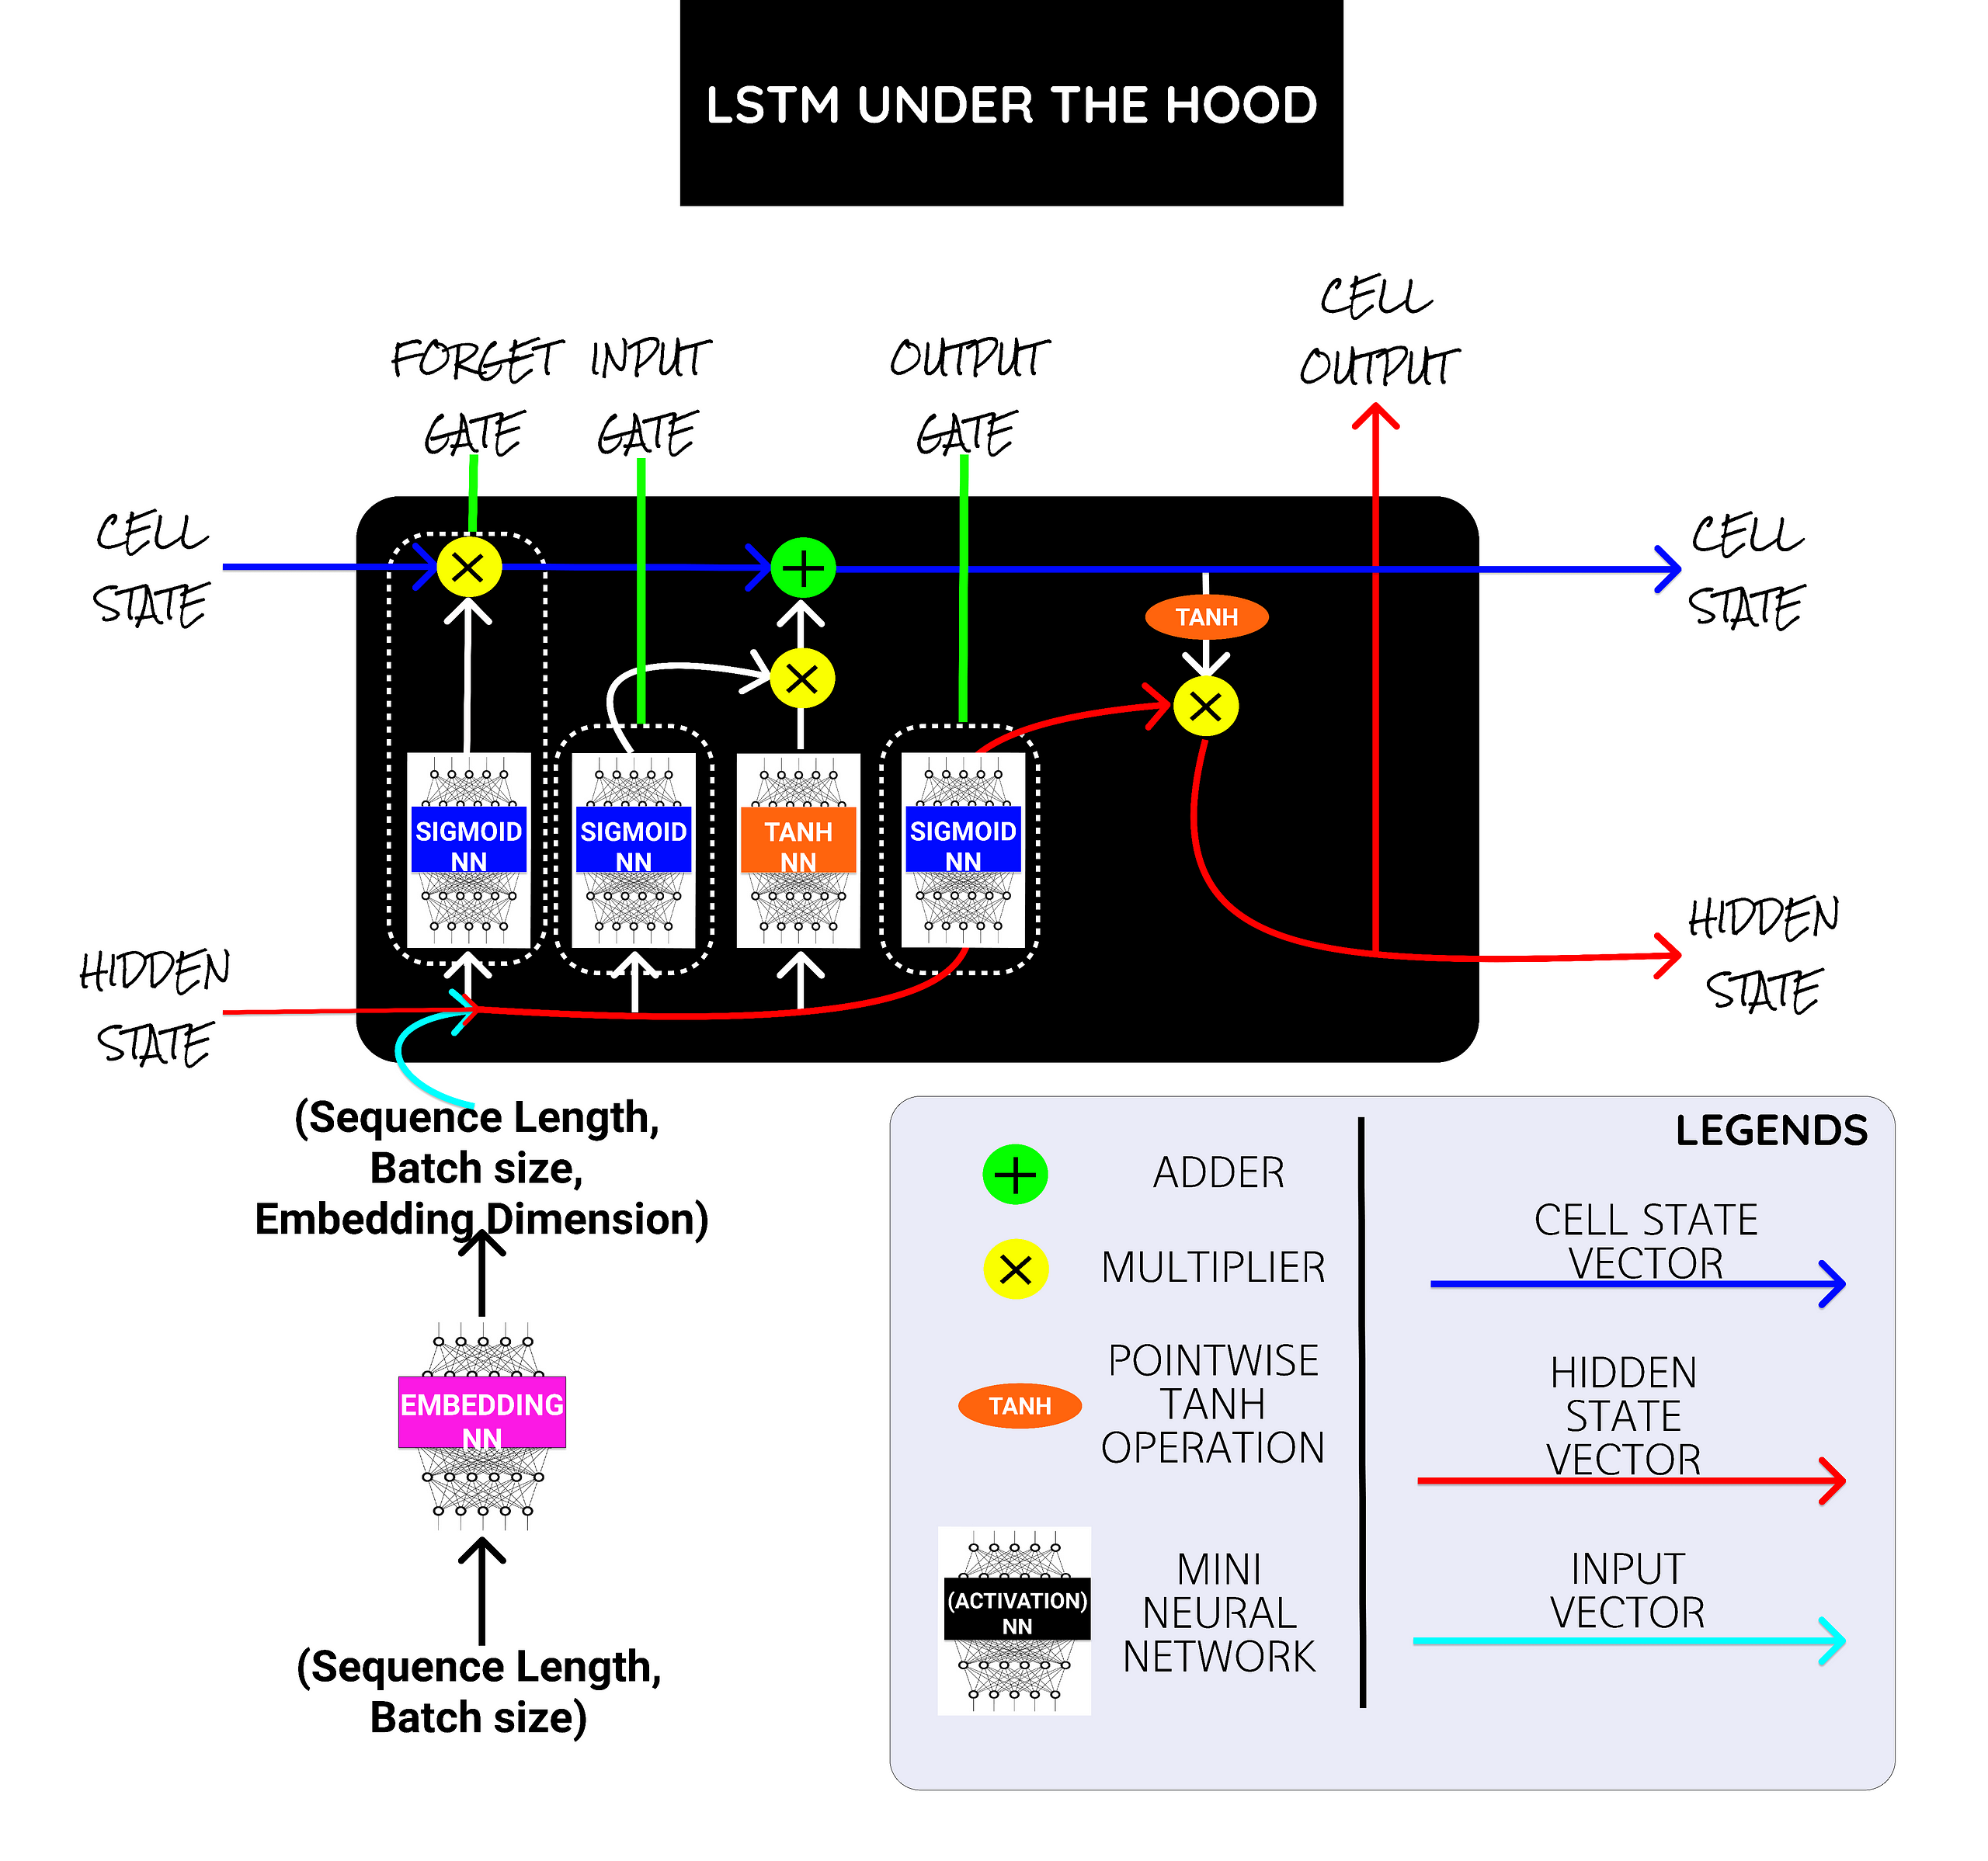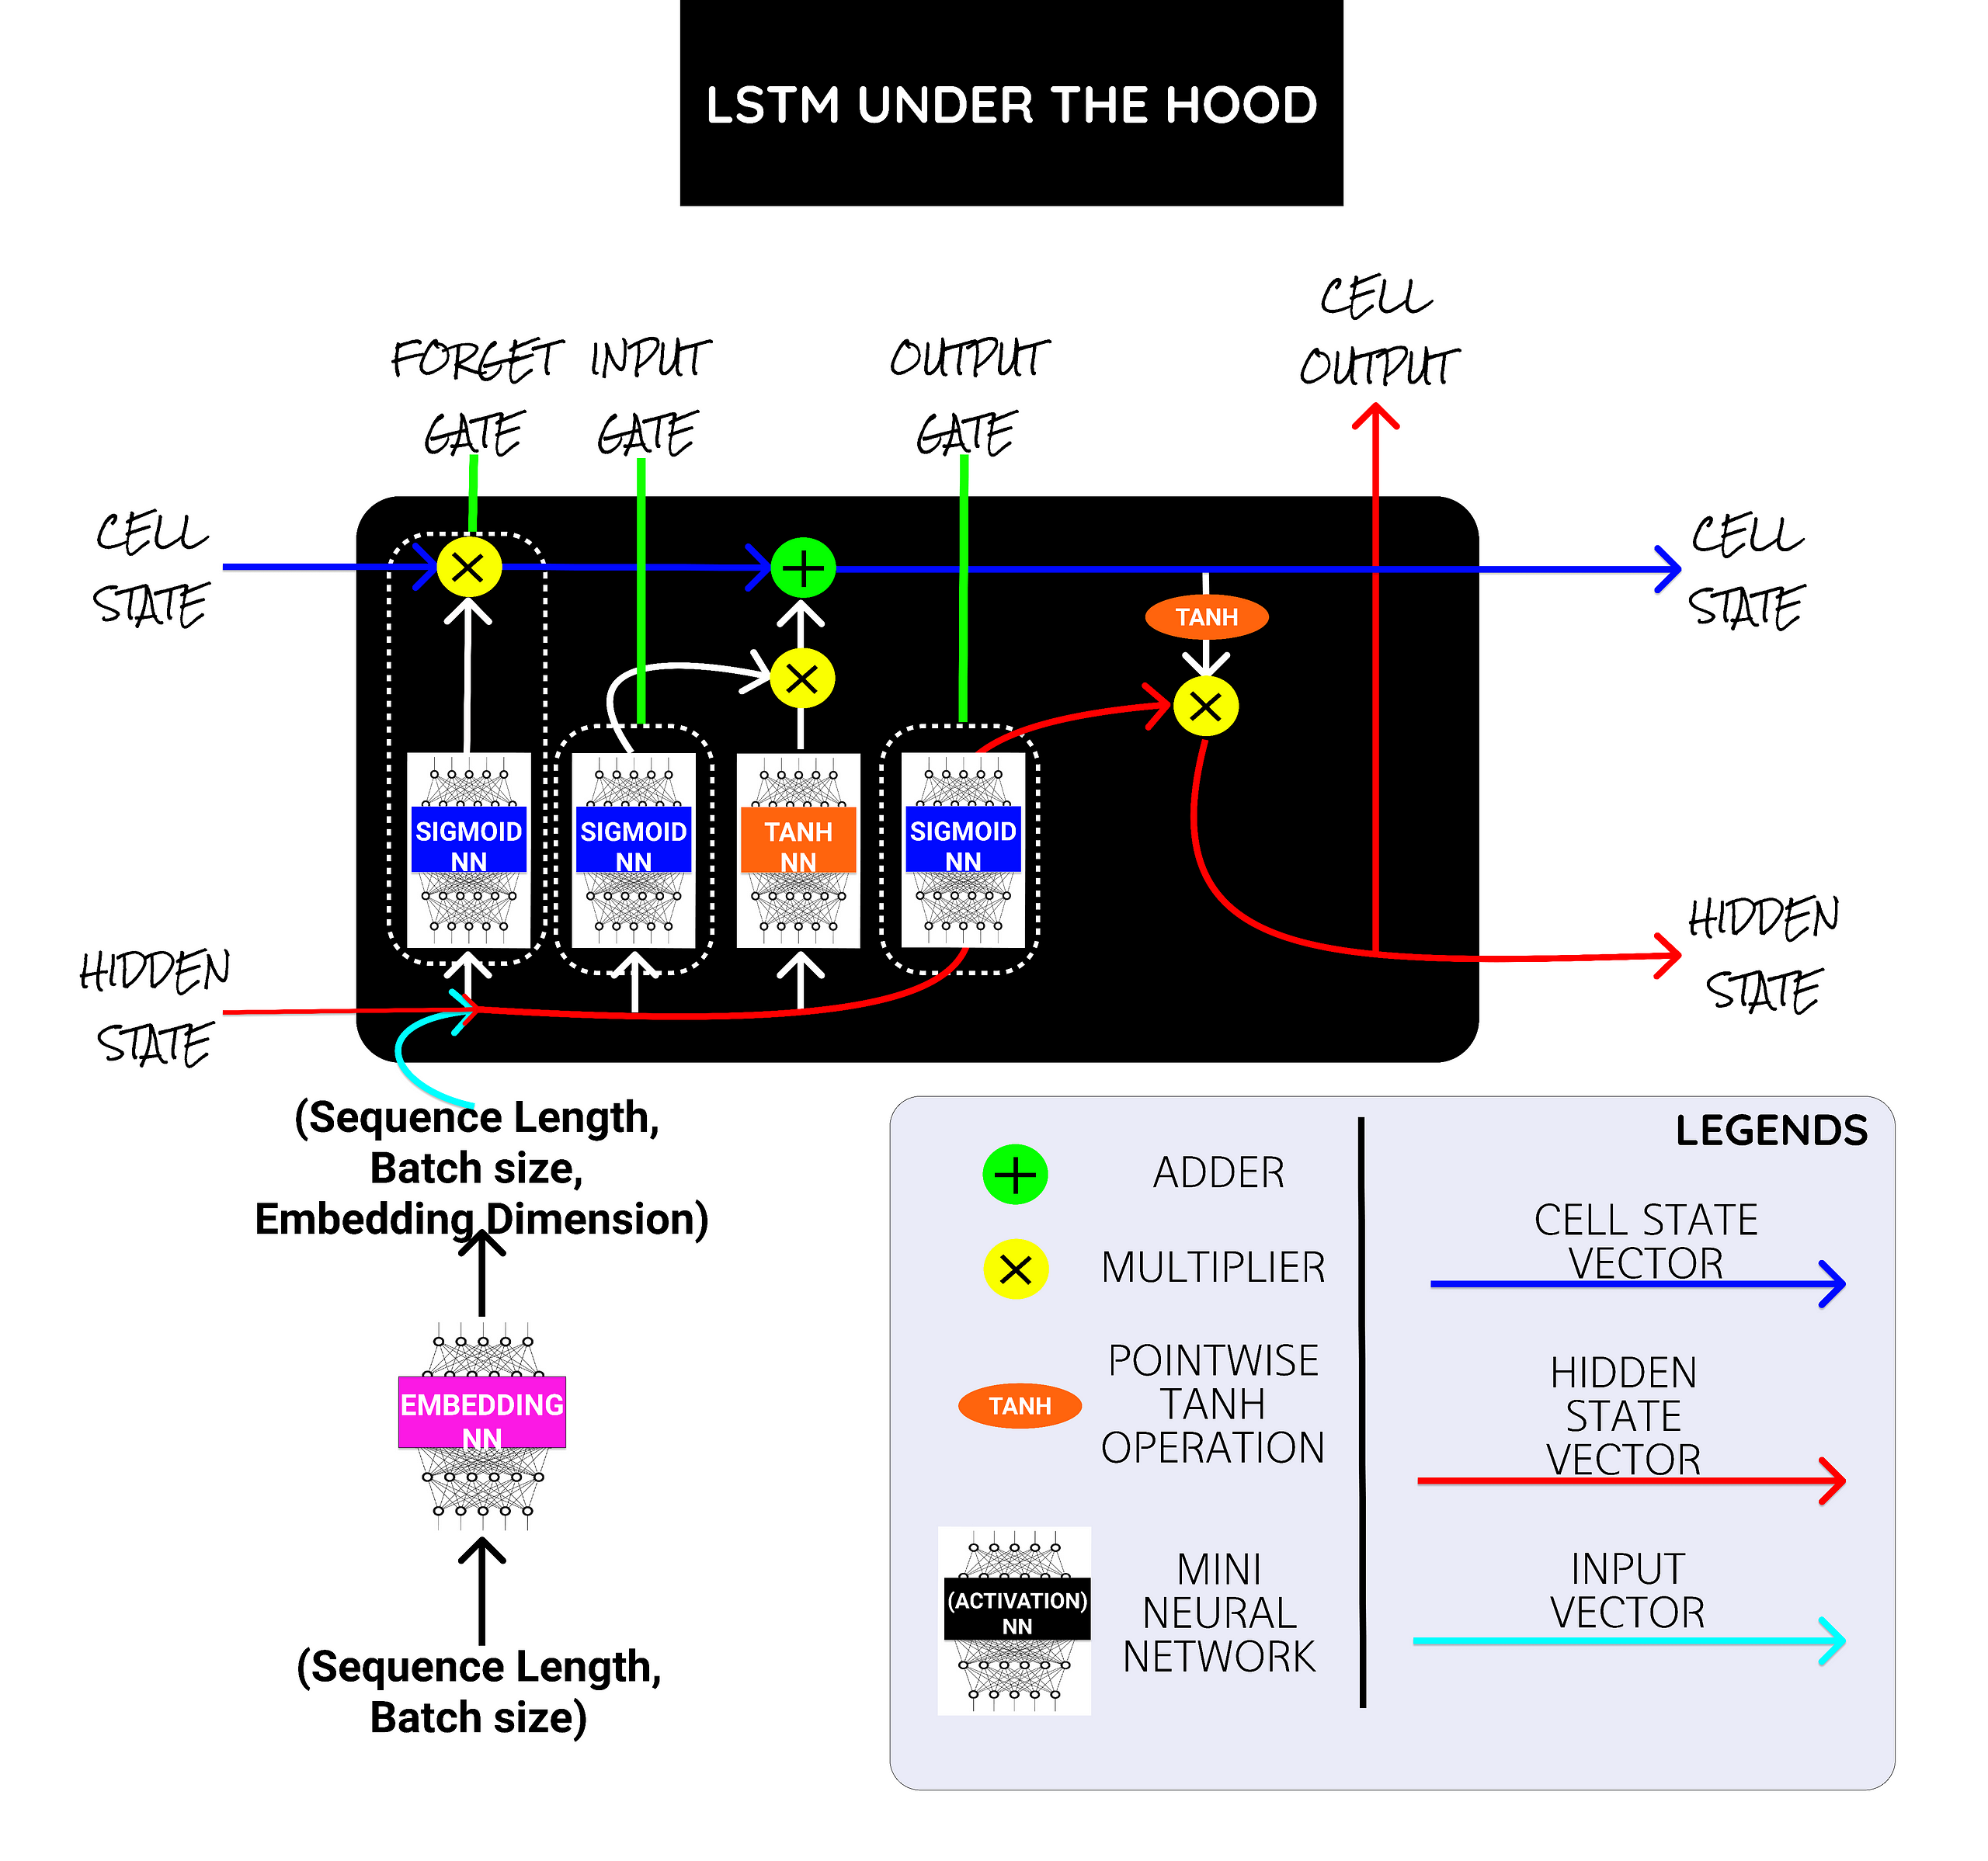
- TanH NN → Squishes the values between -1 and 1. Helps to regulate the vector values from either getting exploded to the maximum or shrank to the minimum.
- The hidden state and the cell state : the context vector

### 4. Encoder Model Architecture (Seq2Seq)

- Before moving to seq2seq model, we need to create Encoder ,Decoder and create a interface between them in the seq2seq model.
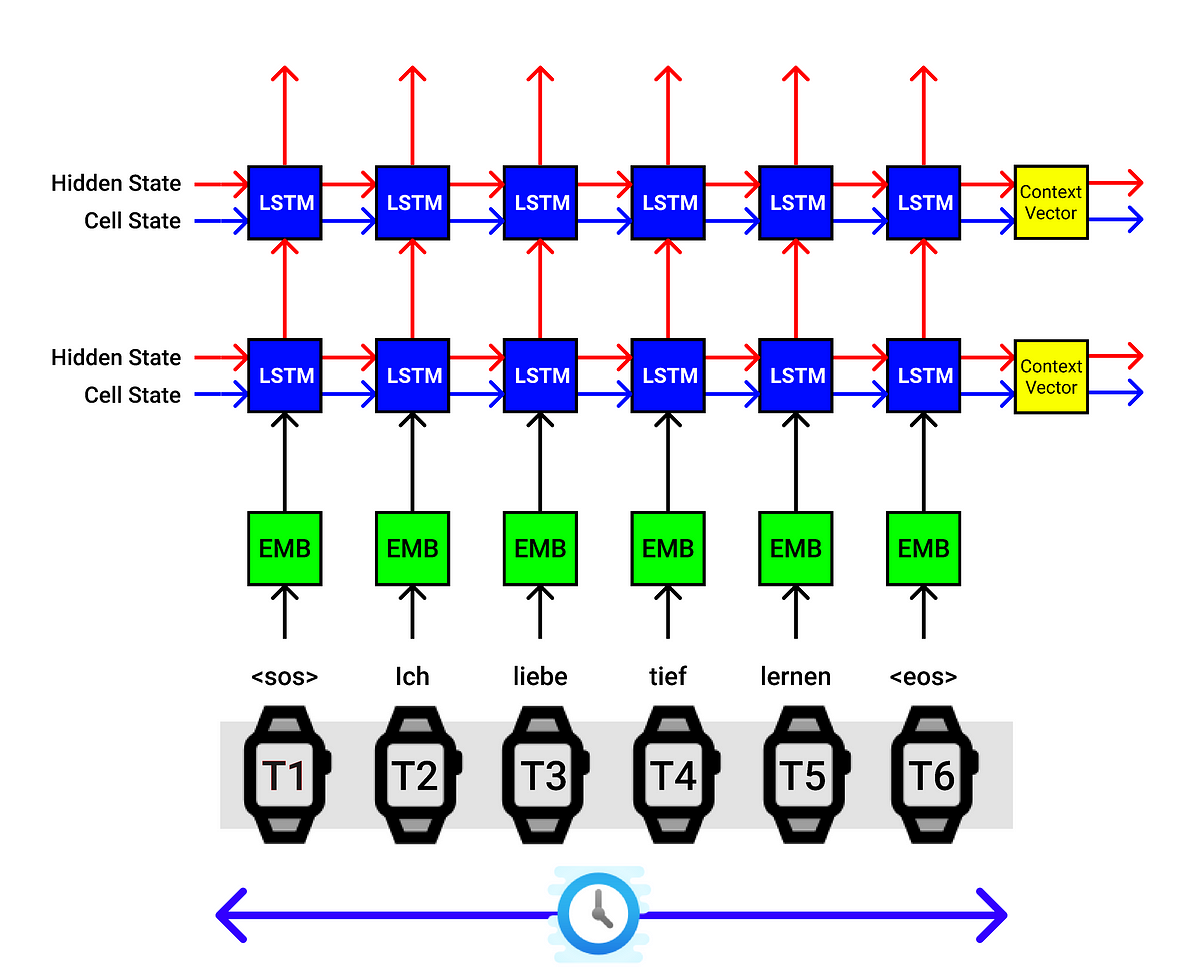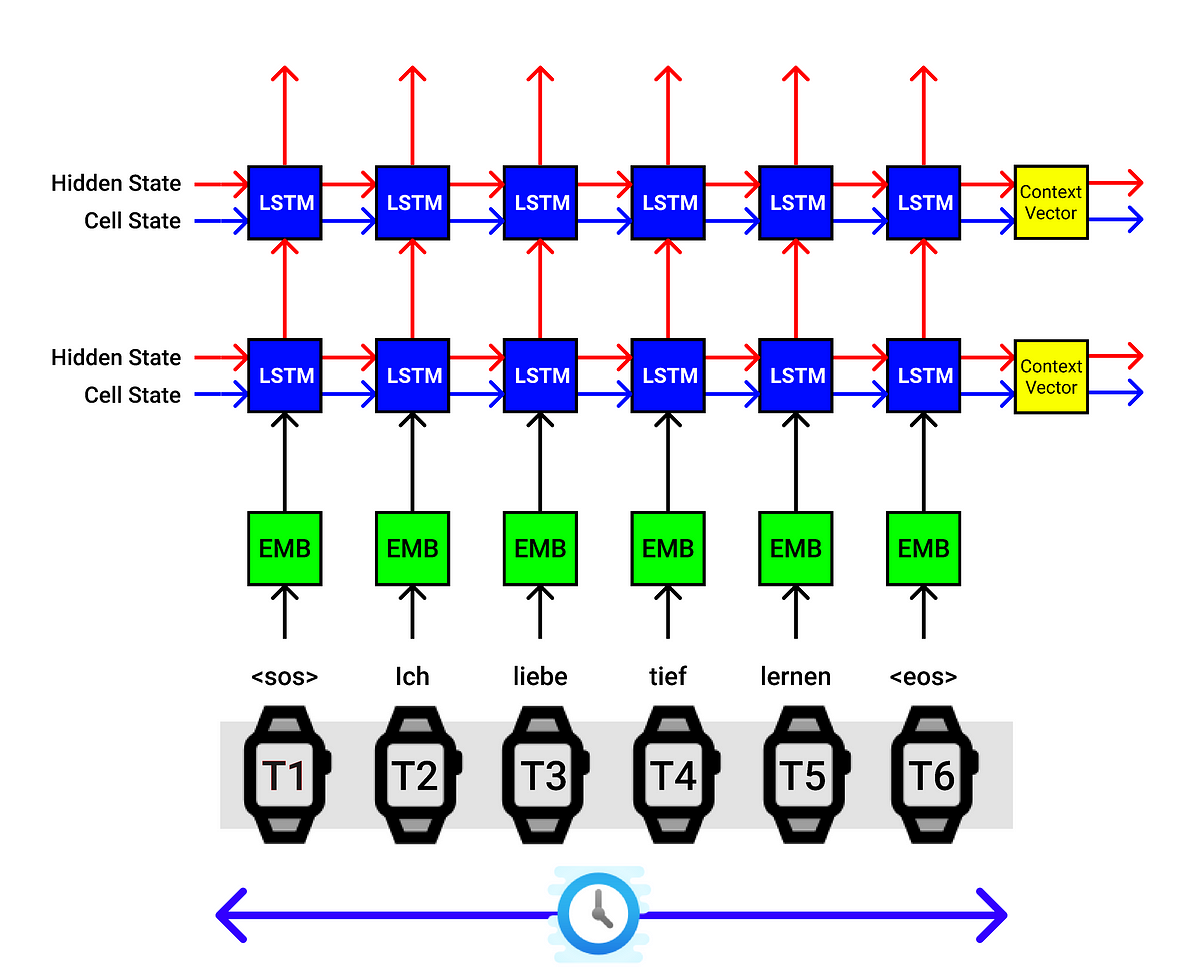
- start of sequence "SOS" and the end of sentence "EOS"
- word embedding layer [shown in green block], which converts the __input indexed word into a dense vector__ representation
- the hs and cs captured some vector representation of the sentence so far.
- At time step-0, the hidden state and cell state are either initialized fully of zeros or random numbers.
- 2 layer LSTM : obtain 2 context vectors stacked on top as the final output.
- Say we have a batch size of 5 (Experimental), then we pass 5 sentences at a time to the Encoder, which looks like the below figure.

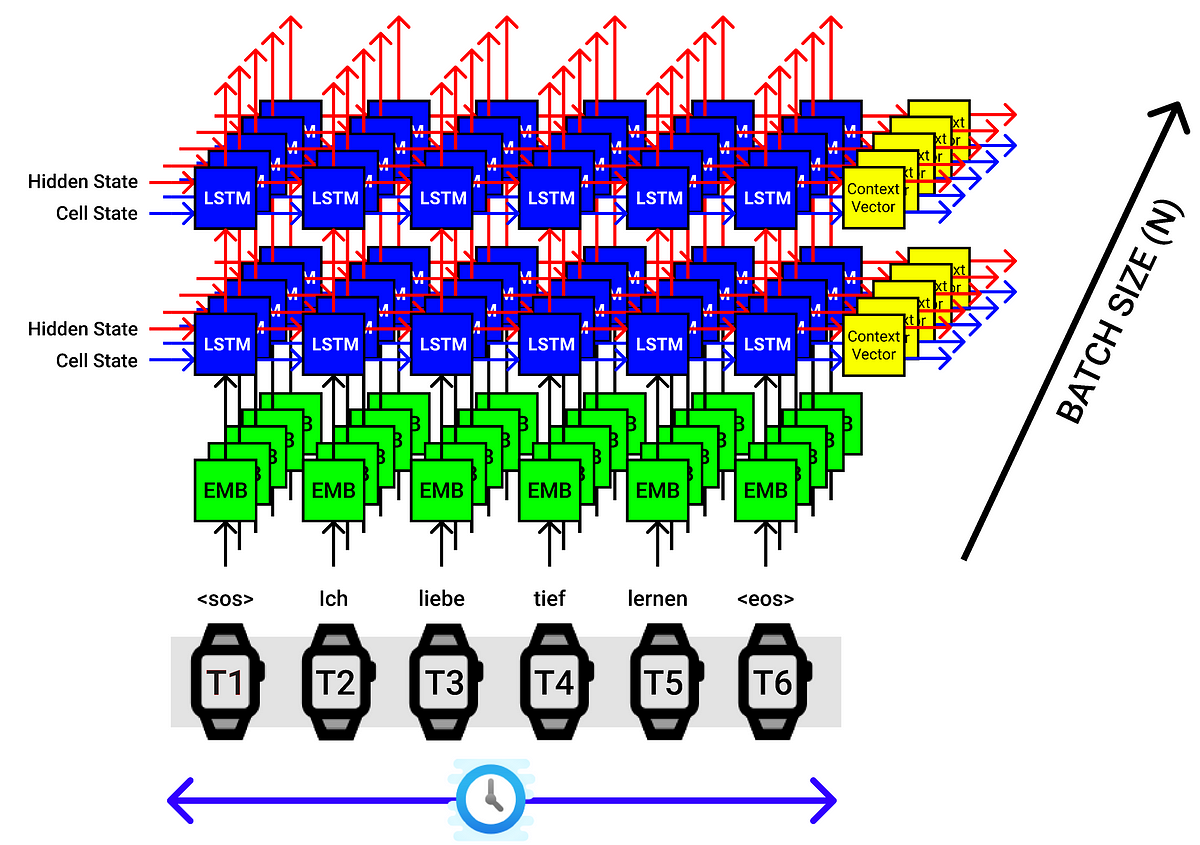
- a batch size of 5 (experimental), where we consider 5 input sentences and the first token from each sentences is sent to the encoder at a time. 

### 5. Encoder Code Implementation (Seq2Seq)

In [204]:
# 내가 따로 뺌
hidden_size = 1024
num_layers = 2
encoder_dropout = 0.5

In [205]:
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
  # def __init__(..., src_embedding):
    super(EncoderLSTM, self).__init__()

    # Size of the one hot vectors that will be the input to the encoder 
    #  @one hot vec라기 보단 단어 사전 크기에서 각 단어에 해당하는 인덱스에 emb size만큼 dense 표현이 저장되어 있어서 one hot vec이라 한 듯
    #self.input_size = input_size

    # Output size of the word embedding NN
    #self.embedding_size = embedding_size

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Regularization parameter
    self.dropout = nn.Dropout(p)
    self.tag = True # ?? 굳이 

    # Shape --------------------> (5376, 300) [input size, embedding dims]
    # if src_embedding is None:
    if flag_pretrained_emb :
        self.embedding = src_embedding # nn.LSTM(len(src_embedding[0]) 로 해야 더 안전할 듯
    else :
        self.embedding = nn.Embedding(input_size, embedding_size)
        
    # Shape -----------> (300, 2, 1024) [embedding dims, hidden size, num layers]
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

  # Shape of x (26, 32) [Sequence_length, batch_size]
  def forward(self, x):

    # Shape -----------> (26, 32, 300) [Sequence_length , batch_size , embedding dims]
    embedding = self.dropout(self.embedding(x))
    
    # Shape --> outputs (26, 32, 1024) [Sequence_length , batch_size , hidden_size]
    # Shape --> (hs, cs) (2, 32, 1024) , (2, 32, 1024) [num_layers, batch_size size, hidden_size]
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)

    return hidden_state, cell_state

input_size_encoder = len(german.vocab)
encoder_embedding_size = 300 # len(src_embedding[0]) 로 해야 더 안전할 듯
# hidden_size = 1024
# num_layers = 2
encoder_dropout = 0.5

encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                           hidden_size, num_layers, encoder_dropout).to(device)
print(encoder_lstm)

EncoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(8412, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
)


### 6. Decoder Model Architecture (Seq2Seq)

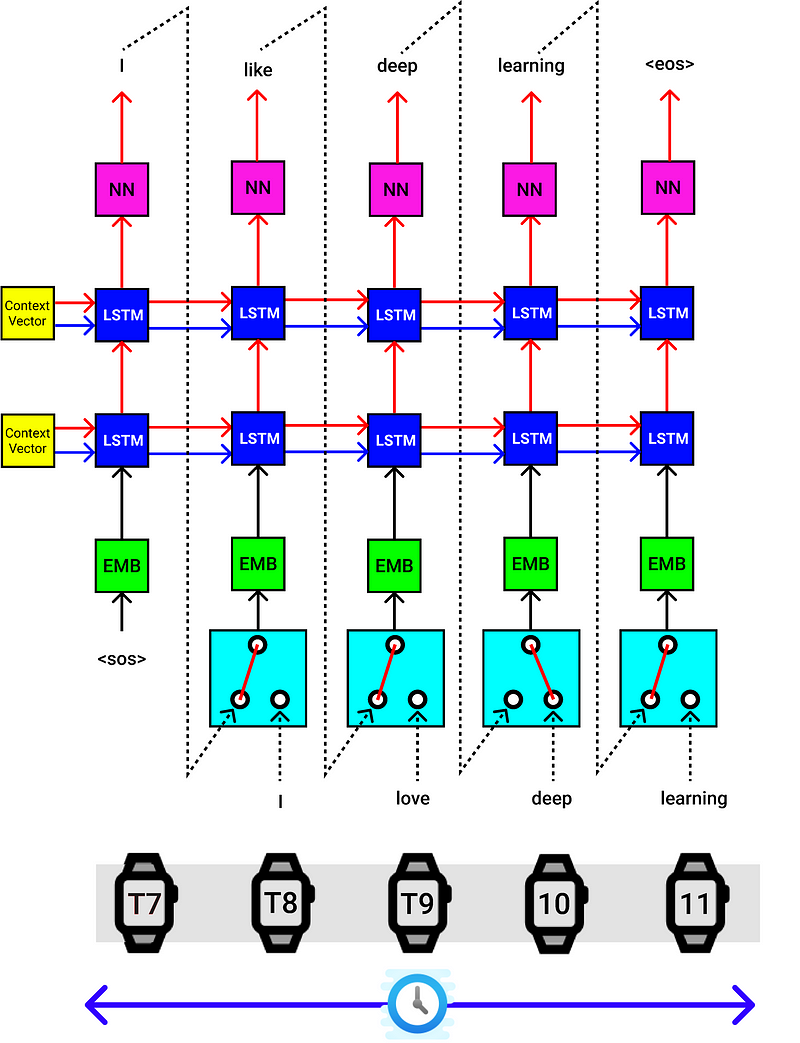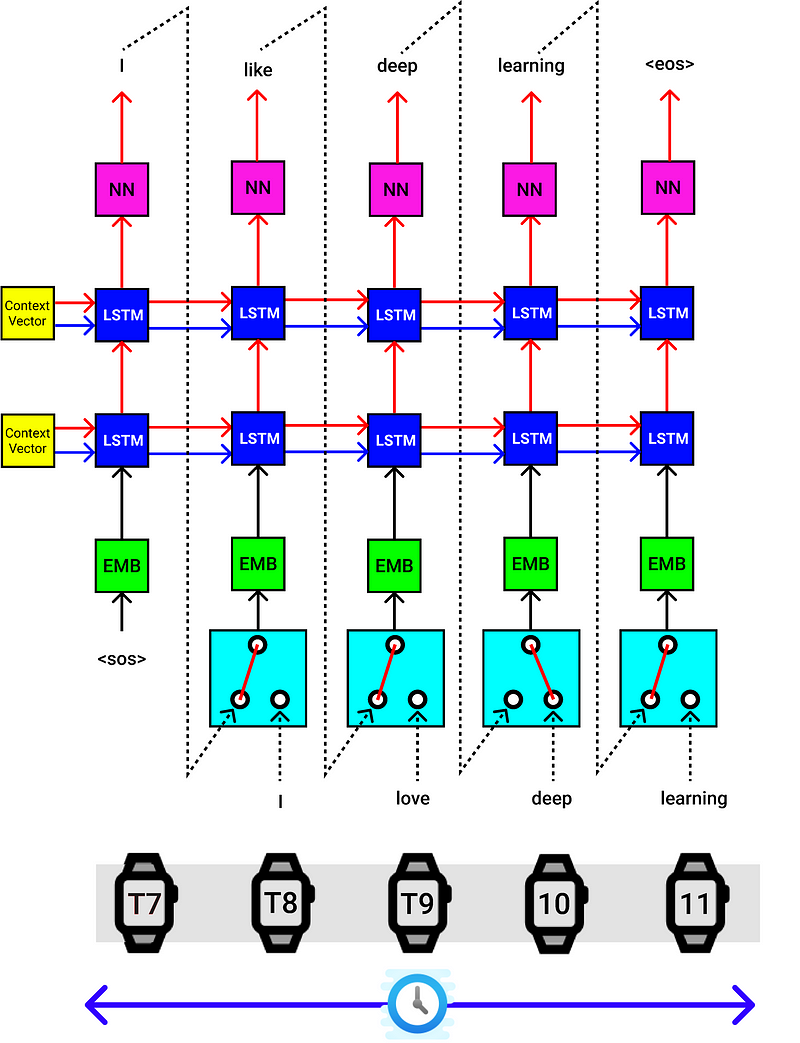
- finally, it is passed through a linear layer [Shown in Pink color], which provides an output English token prediction probabilities (4556 Probabilities), hidden state (hs), Cell State (cs). ?? fc가 왜 hs, cs를 제공한다는 거지
-  

### Teach Force Ratio:
- In addition to other blocks, you will also see the block shown below in the Decoder

- Teach Force Ratio methodWe can send the actual target words to the decoder part while training (Shown in Green Color).
- We can also send the predicted target word, as the input to the decoder (Shown in Red Color).
- Whether sending either of the words (actual target or predicted target) can be regulated with a probability of 50%
- 

### 7. Decoder Code Implementation (Seq2Seq)

In [206]:
class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
  # def __init__(..., trg_embedding):
    super(DecoderLSTM, self).__init__()

    # Size of the one hot vectors that will be the input to the encoder
    #self.input_size = input_size

    # Output size of the word embedding NN
    #self.embedding_size = embedding_size

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Size of the one hot vectors that will be the output to the encoder (English Vocab Size)
    self.output_size = output_size

    # Regularization parameter
    self.dropout = nn.Dropout(p)

    # Shape --------------------> (5376, 300) [input size, embedding dims]
    if flag_pretrained_emb :
        self.embedding = trg_embedding # nn.LSTM(len(tar_embedding[0]) 로 해야 안전할 듯
    else :        
        self.embedding = nn.Embedding(input_size, embedding_size)

    # Shape -----------> (300, 2, 1024) [embedding dims, hidden size, num layers]
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

    # Shape -----------> (1024, 4556) [embedding dims, hidden size, num layers] @ 잘못적은 듯 [h size, English Vocab Size]
    self.fc = nn.Linear(hidden_size, output_size)

  # Shape of x (32) [batch_size]
  def forward(self, x, hidden_state, cell_state):

    # Shape of x (1, 32) [1, batch_size]
    x = x.unsqueeze(0)

    # Shape -----------> (1, 32, 300) [1, batch_size, embedding dims]
    embedding = self.dropout(self.embedding(x))

    # Shape --> outputs (1, 32, 1024) [1, batch_size , hidden_size]
    # Shape --> (hs, cs) (2, 32, 1024) , (2, 32, 1024) [num_layers, batch_size size, hidden_size] (passing encoder's hs, cs - context vectors)
    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))

    # Shape --> predictions (1, 32, 4556) [ 1, batch_size , output_size]
    predictions = self.fc(outputs)

    # Shape --> predictions (32, 4556) [batch_size , output_size]
    predictions = predictions.squeeze(0)

    return predictions, hidden_state, cell_state

input_size_decoder = len(english.vocab)
decoder_embedding_size = 300 # len(tar_embedding[0]) 또는 tar_embedding.shape[1]로 해야 더 안전할 듯
# hidden_size = 1024
# num_layers = 2
decoder_dropout = 0.5
output_size = len(english.vocab)

decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                           hidden_size, num_layers, decoder_dropout, output_size).to(device)
print(decoder_lstm)

DecoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(8043, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=8043, bias=True)
)


### 8. Seq2Seq (Encoder + Decoder) Interface

1. Provide both input (German) and output (English) sentences.
2. Pass the input sequence to the encoder and extract context vectors.
3. Pass the output sequence to the decoder, context vecotr from encoder to produce the predicted output sequence.

In [207]:
for batch in train_iterator:
  print(batch.src.shape)
  print(batch.trg.shape)
  break

x = batch.trg[1]
print(x)

torch.Size([7, 32])
torch.Size([10, 32])
tensor([132,   4,  20, 238,   4,  26,  20,  59,   6,   8,  26,  59,   4,  15,
         29, 146,  29,   8, 116,  42,  30,   4,  71,  71, 191, 837, 204,  49,
         30,  15, 191,  71], device='cuda:0')


In [208]:
# batch.trg[0]

### 9. Seq2Seq (Encoder + Decoder) Code Implementation

In [209]:
class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM

  def forward(self, source, target, tfr=0.5):
    # Shape - Source : (10, 32) [(Sentence length German + some padding), Number of Sentences]
    batch_size = source.shape[1]

    # Shape - Source : (14, 32) [(Sentence length English + some padding), Number of Sentences]
    target_len = target.shape[0]
    target_vocab_size = len(english.vocab)
    
    # Shape --> outputs (14, 32, 5766) 
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

    # Shape --> (hs, cs) (2, 32, 1024) ,(2, 32, 1024) [num_layers, batch_size size, hidden_size] (contains encoder's hs, cs - context vectors)
    hidden_state, cell_state = self.Encoder_LSTM(source)

    # Shape of x (32 elements)
    x = target[0] # Trigger token <SOS>

    for i in range(1, target_len):
      # Shape --> output (32, 5766) 
      output, hidden_state, cell_state = self.Decoder_LSTM(x, hidden_state, cell_state)
      outputs[i] = output
      best_guess = output.argmax(1) # 0th dimension is batch size, 1st dimension is word embedding
      x = target[i] if random.random() < tfr else best_guess # Either pass the next word correctly from the dataset or use the earlier predicted word

    # Shape --> outputs (14, 32, 5766) 
    return outputs

__G SummaryWriter __
TensorBoard 시각화 도구와 함께 사용됨. 주로 모델 학습 중에 발생하는 다양한 지표들을 시각적으로 모니터링하고 디버깅하는 데 사용됩니다.

모델의 훈련 및 평가 중에 발생하는 정보를 기록합니다. 주로 다음과 같은 작업을 수행합니다:

1. 손실(loss) 및 성능 지표(metrics) 기록
1. 모델 파라미터 및 그래디언트 기록: 모델의 가중치(weight) 및 그래디언트를 시각화하여 학습 과정을 이해하고 모델의 개선 여부를 추적할 수 있습니다.
1. 이미지 및 텐서 기록: 훈련 중에 생성된 이미지, 텐서 등을 기록하여 시각화할 수 있습니다.
1. 학습 과정 모니터링: 학습 과정에서 발생하는 다양한 이벤트(예: 학습률 변화, 배치 처리 시간 등)를 기록하여 모델의 동작을 이해하고 최적화할 수 있습니다.

SummaryWriter를 사용하여 기록된 정보는 TensorBoard와 같은 시각화 도구를 사용하여 시각화

In [210]:
# Hyperparameters

learning_rate = 0.001
writer = SummaryWriter(f"runs/loss_plot")
step = 0

model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [211]:
model

Seq2Seq(
  (Encoder_LSTM): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(8412, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  )
  (Decoder_LSTM): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(8043, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=8043, bias=True)
  )
)

In [212]:
# german.init_token # > '<sos>'
# test = [token.text.lower() for token in spacy_german("I am a boy")]
# test.insert(0, german.init_token)
# test # > ['<sos>', 'i', 'am', 'a', 'boy']

In [213]:
def translate_sentence(model, sentence, german, english, device, max_length=50):
    # spacy_ger = spacy.load("de_core_news_sm")
    spacy_ger = spacy.load("fr_core_news_sm")

    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, german.init_token) # 기존 idx부터 한 칸씩 뒤로 밀려남
    tokens.append(german.eos_token)
    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.Encoder_LSTM(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.Decoder_LSTM(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]

def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        # G vars()
        #  객체의 속성들을 딕셔너리 형태로 반환 ;객체의 __dict__ 속성을 반환
        #  객체의 __dict__ 속성은 해당 객체의 모든 속성을 담고 있는 딕셔너리
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)

def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss):
    print('saving')
    print()
    state = {'model': model,'best_loss': best_loss,'epoch': epoch,'rng_state': torch.get_rng_state(), 'optimizer': optimizer.state_dict(),}
    torch.save(state, '/data/hwyu/seq2seq/checkpoint-NMT')
    torch.save(model.state_dict(),'/data/hwyu/seq2seq/checkpoint-NMT-SD')

In [214]:
# # example = test_data[4]
# # vars(example)["src"]

# for data in train_data:
#     print(data.src)
#     # print("German - ",*data.src, " Length - ", len(data.src))
#     break
# # train_data[0]

In [215]:
# train_fr_sub[2000]
# train_en_sub[2000]
test_fr[54]
test_en[54]

'IT WOULD BE A BURNING SHAME UPON YOU EVEN NOW IF SHE AND I EXCHANGED A WORD'

In [ ]:
from tqdm import tqdm

epoch_loss = 0.0
num_epochs = 100
best_loss = 999999
best_epoch = -1
# sentence1 = "ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster"
# sentence1 = train_fr_sub[2000]
sentence1 = test_fr[54]
ts1  = []

for epoch in tqdm(range(num_epochs)):
  print("Epoch - {} / {}".format(epoch+1, num_epochs))
  model.eval()
  translated_sentence1 = translate_sentence(model, sentence1, german, english, device, max_length=50)
  print(f"Translated example sentence 1: \n {translated_sentence1}")
  ts1.append(translated_sentence1)
 
  score = bleu(test_data[1:100], model, german, english, device)
  print(f"Bleu score {score*100}")

  model.train(True)
  for batch_idx, batch in enumerate(train_iterator):
    input = batch.src.to(device)
    target = batch.trg.to(device)

    # Pass the input and target for model's forward method
    output = model(input, target)
    output = output[1:].reshape(-1, output.shape[2])
    target = target[1:].reshape(-1)

    # Clear the accumulating gradients
    optimizer.zero_grad()

    # Calculate the loss value for every epoch
    loss = criterion(output, target)

    # Calculate the gradients for weights & biases using back-propagation
    loss.backward()

    # Clip the gradient value is it exceeds > 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    # Update the weights values using the gradients we calculated using bp 
    optimizer.step()
    step += 1
    epoch_loss += loss.item()
    writer.add_scalar("Training loss", loss, global_step=step)

  if epoch_loss < best_loss:
    best_loss = epoch_loss
    best_epoch = epoch
    checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss) 
    if ((epoch - best_epoch) >= 10):
      print("no improvement in 10 epochs, break")
      break
  print("Epoch_Loss - {}".format(loss.item()))
  print()
  
print(epoch_loss / len(train_iterator)) # ?? 분모가 epoch * len(train_iterator) 아닌가 

score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score*100:.2f}")

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Epoch - 1 / 100
Translated example sentence 1: 
 ['haidee', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright', 'bright']
Bleu score 0.0
saving



  1%|▍                                       | 1/100 [02:50<4:40:48, 170.19s/it]

Epoch_Loss - 6.223031044006348

Epoch - 2 / 100
Translated example sentence 1: 
 ['what', 'he', 'he', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', '<eos>']
Bleu score 0.0


  2%|▊                                       | 2/100 [05:38<4:36:23, 169.22s/it]

Epoch_Loss - 5.903017044067383

Epoch - 3 / 100
Translated example sentence 1: 
 ['it', 'is', 'the', 'to', 'i', 'i', 'to', 'to', 'to', 'to', 'you', 'to', 'to', '<eos>']


In [ ]:
# !kill 38917
# %load_ext tensorboard 
# # %reload_ext tensorboard

# %tensorboard --logdir runs/
# # %tensorboard --logdir runs/ --port <port_number>

# 터미널 또는 명령 프롬프트에서 다음 명령을 실행
#   TensorBoard가 localhost의 기본 포트(일반적으로 6006)에서 실행
#   http://localhost:6006 (또는 TensorBoard가 실행된 포트)
#   TensorBoard를 열고 "Scalars" 탭을 선택하면 "Training loss"와 같은 이름의 그래프가 표시
# !tensorboard --logdir=runs

### 11. Seq2Seq Model Inference

In [ ]:
progress  = []
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
for i, sen in enumerate(ts1):
  progress.append(TreebankWordDetokenizer().detokenize(sen))
# print(progress)
# for sentence in progress:
#     print(sentence)

In [ ]:
# progress_df = pd.DataFrame(data = progress, columns=['Predicted Sentence'])
# progress_df.index.name = "Epochs"
# progress_df.to_csv('/content/predicted_sentence.csv')
# progress_df.head()

In [ ]:
print(test_en[41:44])
print()
print(test_fr[41:44])

#### Model Inference

In [ ]:
model.eval()
# test_sentences  = ["Zwei Männer gehen die Straße entlang", "Kinder spielen im Park.", "Diese Stadt verdient eine bessere Klasse von Verbrechern. Der Spaßvogel"]
# actual_sentences  = ["Two men are walking down the street", "Children play in the park", "This city deserves a better class of criminals. The joker"]
test_sentences  = test_fr[41:44] 
actual_sentences = test_en[41:44]
pred_sentences = []

for idx, i in enumerate(test_sentences):
  model.eval()
  translated_sentence = translate_sentence(model, i, german, english, device, max_length=50)
  progress.append(TreebankWordDetokenizer().detokenize(translated_sentence))
  print("German : {}".format(i))
  print("Actual Sentence in English : {}".format(actual_sentences[idx]))
  print("Predicted Sentence in English : {}".format(progress[-1]))
  print()

In [ ]:
# 코드 변경시 에러 원인 가능성 
'''
dim=300

input_size_encoder = len(german.vocab)
encoder_embedding_size = 300 # len(src_embedding[0])
# hidden_size = 1024
# num_layers = 2
encoder_dropout = 0.5

self.embedding = src_embedding
self.LSTM = nn.LSTM(embedding_size # nn.LSTM(src_embedding[1] 로 해야 더 안전할 듯

self.embedding = trg_embedding # nn.LSTM(trg_embedding[1] 로 해야 안전할 듯
self.LSTM = nn.LSTM(embedding_size

input_size_decoder = len(english.vocab)
decoder_embedding_size = 300 # len(tar_embedding[0]) 또는 tar_embedding.shape[1]로 해야 더 안전할 듯
# hidden_size = 1024
# num_layers = 2
decoder_dropout = 0.5
output_size = len(english.vocab)

target_vocab_size = len(english.vocab)
'''

# 데이터 변경시 성능 저하 우려 
'''
max_size=10000, min_freq=3

max_length=50

spacy_ger = spacy.load("de_core_news_sm") # 그냥 spacy_german 이거 쓰면 되잖아 
'''

''' 하드 코딩
# sentence1 = "ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster"

test_sentences  = ["Zwei Männer gehen die Straße entlang", "Kinder spielen im Park.", "Diese Stadt verdient eine bessere Klasse von Verbrechern. Der Spaßvogel"]
actual_sentences  = ["Two men are walking down the street", "Children play in the park", "This city deserves a better class of criminals. The joker"]
'''